![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# Univariate LSTM, Single Step Forecast

## Introduction 
This tutorial is to demonstrate the process to build LSTM with the Univariate Time Series Data and forecast single step data<br>
It consists of 2 major parts which are:

1. Demonstration of Building LSTM using Synthetic data 
2. Exercise of building LSTM using shampoo sales data.


>**Instruction** : <br>
The instructor will code with you and guide you in the process of building the LSTM model using Synthetic data.<br>
You are required to complete the exercise after the demonstration.

## What will we accomplish?
First, we will show the step in building the LSTM : 

Step 1. Data Preparation (Data Splitting, Data Sequencing, Data Normalization and Batching the Data)<br>
Step 2. Model Configuration (Vanilla LSTM , Stacked LSTM , Bidirectional LSTM)<br>
Step 3. Train the model <br>
Step 4. Validate the model using the learning curve <br>
Step 5. Evaluation Metrics such as MSE <br>
Step 6. Plot the forecast result

First, let's import the package needed.

In [1]:
%%capture
# pip install this package to view the summary of model  
# used jupyter install due to it does not have conda version
# %%capture suppress information of torchsummaryX installation
!pip install torchsummaryX

In [2]:
#import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
from scipy import stats
from torchsummaryX import summary

# Part 1 : Demonstration of Building LSTM using Synthetic Data

## Hyperparameter
Define the hyperparameter that needs to be tuned.

In [3]:
split_ratio = 0.70
num_epochs = 800
window_size = 2
batch_size = 10

# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and having the ability to perform the forecasting <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it to series data by using `pd.Series`.

In [4]:
# Create Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [5]:
# Create time index for Synthetic Data
univariate_series =pd.Series(univariate_series,pd.date_range("1/1/2020",
                                                             periods=len(univariate_series),
                                                            freq='D'))
univariate_series.head()

2020-01-01     0
2020-01-02    10
2020-01-03    20
2020-01-04    30
2020-01-05    40
Freq: D, dtype: int32

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As seen in the graph below, there is an increasing trend in the data.

>**Instruction** : <br>
Plot the graph using `univariate_series.plot` with the title `Synthetic Data"`

Text(0.5, 1.0, 'Synthetic Data')

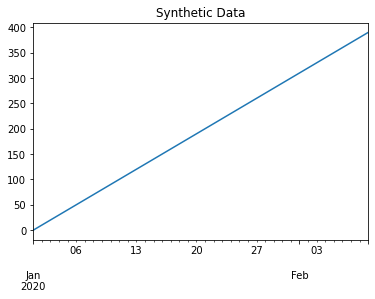

In [6]:
### BEGIN SOLUTION

univariate_series.plot()
plt.title("Synthetic Data")

### BEGIN SOLUTION

## Data Splitting
In Deep Learning, we will split the data into training and test dataset. The training data is used to train the model whereas the test data is used to validate the performance of the model
>**Instruction** : <br>
Split the data by indexing. Remember to split the time index for later use.

In [7]:
# Split the data with ratio as state in hyperparameter
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [8]:
### BEGIN SOLUTION
# Split data by indexing 
train_data = univariate_series.values[:split_data]
test_data = univariate_series.values[split_data:]
train_time = univariate_series.index[:split_data]
test_time = univariate_series.index[split_data:]
### END SOLUTION
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
Standardize the data to have 0 mean and unit variance in order to make our model converge faster
>**Instruction** : <br>
Use `StandardScaler()` as the scaler for the data. Create scaled data using `scaler.transform` and store in respective `train_data_standard` and `test_data_standard`

In [9]:
### BEGIN SOLUTION
# Scaler the data
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.reshape(-1, 1))

### END SOLUTION

In [10]:
print(f"train_data_standard :{train_data_standard.shape}")

train_data_standard :(28, 1)


## Data Sequencing
Sequencing the data by taking in the univariate series into `feature` and `label`<br>
<img src = "../../picture/Data Sequencing in Univariate Single Step.png"  width="300" height  ="300" align="center" />

>**Instruction** : <br>
Build a data sequencing function that can perform the sliding window to the unvariate data.


In [11]:
# Data sequencing function 
### BEGIN SOLUTION

def univariate_single_step(sequence, window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


### END SOLUTION

Sanity check the shape after sequencing the data

In [12]:
trainX ,trainY =  univariate_single_step(train_data_standard,window_size)
testX , testY = univariate_single_step(test_data_standard,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")


trainX shape:(26, 2, 1) trainY shape:(26, 1)

testX shape:(10, 2, 1) testX shape:(10, 1)


## Data Transformation
Before we train the model, we need to transform our data from `ndarray` to `torch tensor`.
>**Instruction** : <br>
Use `torch.from_numpy(data).type(torch.Tensor)` to transform your data from `numpy array` to `torch tensor`

In [13]:
# Transform to Pytorch tensor

### BEGIN SOLUTION
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

### END SOLUTION

print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:torch.Size([26, 2, 1]) trainY shape:torch.Size([26, 1])

testX shape:torch.Size([10, 2, 1]) testY shape:torch.Size([10, 1])


Perform sanity check on the shape to make sure the transform is successful.

In [14]:
print(f"Features are now in the shape of {trainX.shape} while labels are now in the shape of {trainY.shape}\n")
print("feature\n"+str(trainX.shape[0])+" = total number of data ")
print(str(trainX.shape[1])+" = window size ")
print(str(trainX.shape[2])+" = number of time series\n")
print("label\n"+str(trainY.shape[0])+" = number of data")
print(str(trainY.shape[1])+" = number of step\n")

Features are now in the shape of torch.Size([26, 2, 1]) while labels are now in the shape of torch.Size([26, 1])

feature
26 = total number of data 
2 = window size 
1 = number of time series

label
26 = number of data
1 = number of step



## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
    1. First, use `TensorDataset` to "wrap" the feature and label together.<br>
    2. Then, use `DataLoader` to create an iterator based on the `batch_size`.<br> 

>`shuffle = False` will be selected since we don't want it to break the sequential information between each data

In [15]:
# Create Iterator

### BEGIN SOLUTION

train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

### END SOLUTION

# Step 2 : LSTM Model Configuration 

The method used to create the model is a PyTorch subclass method. <br>

It consists of 2 parts :<br>
1. The first part allows the user to define the structure of the model such as the **number of input unit**, **number of output unit** and **number of hidden unit** as well. 
2. The second part of the method consists of forward() method, which allows the user to control the flow of input data and output data. 

>**How to initialize LSTM?**<br>
 1.`nn.LSTM(number of feature , number of hidden unit,number of layer)`<br>
 2.`nn.Linear(number of hidden, number of step)`<br>

>**The dimension for LSTM in the `forward()` method (Data Flow Protocol)**<br>
*if `number of layer` > 1 , it indicates that it is a stack LSTM*<br><br>
*if `number of directions` = 2 indicates that it is a Bidirectional LSTM*<br><br>
*Input*<br>
`input(batch size,sequence length, number of feature)`<br>
`h_0 (number of layer * number of directions, batch size, number of hidden unit)`<br>
`c_0 (number of layer * number of directions, batch size, number of hidden unit)`<br><br>
*Output*<br>
`output ( batch,seq_len, num_directions * hidden_size)`<br>
`h_n (number of layer* number of directions, batch size,  number of hidden unit)`<br>
`c_n (number of layer* number of directions, batch size,  number of hidden unit)`<br><br>

>**Model structure**<br>
<img src = "../../picture/lstm data flow.png"  width="600" height  ="600" />

>**What is stacked LSTM?**<br>
The LSTM unit(blue rectangle) is stacking as the depth (number of the layer) increases<br>
<img src = "https://img-blog.csdnimg.cn/20190820152709292.png"  width="500" height  ="500" />

>**What is the hidden unit in LSTM?**<br>
The hidden unit known as the number of nodes for the hidden cell (cell state and hidden state of LSTM). You can imagine it as the number of hidden units in the hidden layer of MLP. The hidden unit will concatenate with the sequence length of the data input and perform the subsequence maths operation. The left figure is showing how the hidden unit is concatenating with the sequence input. The right figure is showing how the hidden unit passes through in a sequence by sequence manner.

<table><tr>
<td><img src = "https://miro.medium.com/max/700/1*goJVQs-p9kgLODFNyhl9zA.gif" width="500" height  ="500"/> </td>
<td><img src = "../../picture/hidden_layer_lstm.png"  width="500" height  ="500" /></td>
</tr></table>



## Vanilla LSTM
>**Instruction** : <br>
Follow the instructor's guidance to configure the Vanilla LSTM 


In [16]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers,n_step):
            super(LSTM, self).__init__()
            ### BEGIN SOLUTION
            
            # Number of feature of data
            self.n_feature = n_feature
            
            # Hidden unit dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers
            
            # Number of step ,step =1 -> single step forecast
            self.n_step = n_step 
          

            # Building your LSTM
            # batch_first=True 
            # Configuration -> (number of feature , number of hidden unit,number of layer)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, n_step)
            ### END SOLUTION

        def forward(self, x):
            ### BEGIN SOLUTION
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state with zeros
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # we just want last time step hidden states(output)
            out = out[:, -1, :]
            out = self.fc(out)
            
            ### END SOLUTION
            return out

## Bidirectional LSTM
The only difference in the configuration of **Bidirectional LSTM** and **Vanilla LSTM** is the input configuration of the FC layer(`nn.Linear`). Addition to that, layers of hidden cells (`h0` and `c0`) in a **bidirectional LSTM** has to be multiplied by 2.<br> 

For example : 
`num_directions = 2`, indicated as a bidirectional LSTM<br>

`self.fc = nn.Linear(hidden_dim * num_directions, output_dim)` <br>
`h0 = torch.zeros(self.num_layers* num_directions, x.size(0), self.hidden_dim)`<br>
`c0 = torch.zeros(self.num_layers* num_directions, x.size(0), self.hidden_dim)`

>**Instruction** : <br>
Try to configure the Bidirectional LSTM based on the given information.

In [17]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers,n_step):
        super(BidirectionalLSTM, self).__init__()
        ### BEGIN SOLUTION

        # Number of feature of data
        self.n_feature = n_feature
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        
        # Number of step ,step =1 -> single step forecast
        self.n_step = n_step 

        # Building your LSTM
        # batch_first=True 
        # Configuration -> (number of feature , number of hidden unit,number of layer)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, n_step)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # we just want last time step hidden states(output)
        out = out[:, -1, :]

        # Index hidden state of last time step
        out = self.fc(out)
        
        ### END SOLUTION
        return out

## Input Model 
The model is initiated with the following required attributes: **number of input layer**, **output layer** and **hidden layer**.

>**Instruction** : <br>
Follow the instructor guidance to know how to initiate the model.

How to Use : 
1. Select one of the model base on the application as below and comment out other models
2. IF use Vanilla LSTM, set num_layer = 1 and use `model = LSTM()`
3. IF use stacked LSTM, set num_layer more than 1 and use `model = LSTM()`
4. IF use Bidirectional LSTM, use  `model = BidirectionalLSTM()`

In [18]:
# Arguments for LSTM model

torch.manual_seed(123)

### BEGIN SOLUTION

hidden_dim = 100
number_of_time_series = 1 
n_step = 1 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1 

# Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim,num_layers=num_layers,n_step = n_step)

# Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=timestep, num_layers=num_layers,n_step = n_step)

### END SOLUTION

Define the MSE as loss function and use Adam as the model optimizer

In [19]:
# Loss function 

### BEGIN SOLUTION
loss_fn = torch.nn.MSELoss()
### END SOLUTION

# Optimizer
### BEGIN SOLUTION
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
### END SOLUTION

Summary of the LSTM model
>**How to calculate LSTM Parameter ,`Params`**<br>
Number of FF Neural Network,`g`<br>
RNN -> 1<br>
GRU -> 3<br>
LSTM -> 4<br>
number of hidden unit,`h`<br>
sequence length,`i`<br>
Params = `g × [h(h+i) + h]`<br>

In [20]:
# print the summary of the LSTM model
inputs = torch.zeros((batch_size,window_size,1),dtype=torch.float) # batch size , seq_length , input_dim
print(summary(model,inputs))

       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [10, 2, 100]   41200      40400
1_fc       [100, 1]       [10, 1]     101        100
----------------------------------------------------
                      Totals
Total params           41301
Trainable params       41301
Non-trainable params       0
Mult-Adds              40500
       Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                               
0_lstm            -  [10, 2, 100]   41200      40400
1_fc       [100, 1]       [10, 1]     101        100


# Step 3 : Training
Pipeline :
- Initialize epoch loss and running loss to zero for later use
- Forward Pass
- Calculate MSE
- Zero out optimizer gradient 
- Backward Pass
- Optimizer update 
- Compute running loss for each iteration
- Compute the epoch loss

>**Instruction** : <br>
Follow the instructor guidance to configure the training function

In [21]:

def training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    ### BEGIN SOLUTION
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cumulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for _,(train_X,train_Y) in enumerate(train_iter):
            
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for j,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    ### END SOLUTION
    return train_loss,val_loss

In [22]:
# Start Training 
torch.manual_seed(123)
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimizer,loss_fn,model)

# Step 4 : Validation 
A learning curve is plotted to define how well the data fits in the model.

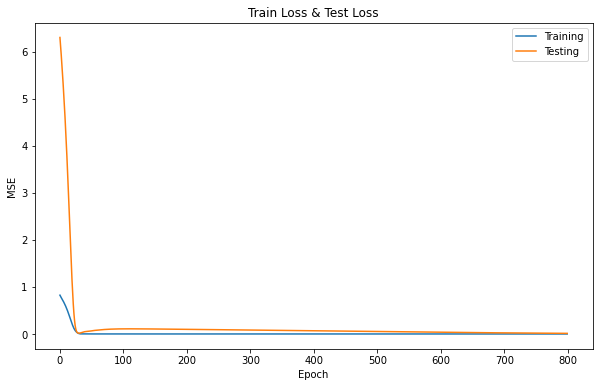

Epoch : 0 , training loss : 0.8245855432290298 , validation loss : 6.3033952713012695
Epoch : 1 , training loss : 0.7965994156323947 , validation loss : 6.127895832061768
Epoch : 2 , training loss : 0.7736826195166662 , validation loss : 5.939906120300293
Epoch : 3 , training loss : 0.7506149514363363 , validation loss : 5.7433552742004395
Epoch : 4 , training loss : 0.7269401504443243 , validation loss : 5.53829288482666
Epoch : 5 , training loss : 0.7024063399204841 , validation loss : 5.323714733123779
Epoch : 6 , training loss : 0.6767991059101545 , validation loss : 5.0982842445373535
Epoch : 7 , training loss : 0.6499223193297019 , validation loss : 4.860601902008057
Epoch : 8 , training loss : 0.6215988775858512 , validation loss : 4.609373092651367
Epoch : 9 , training loss : 0.5916781895435773 , validation loss : 4.343552589416504
Epoch : 10 , training loss : 0.5600472253102523 , validation loss : 4.0624895095825195
Epoch : 11 , training loss : 0.5266448798087927 , validation 

In [23]:
def learning_curve(num_epochs,train_loss,val_loss):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Testing")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Train Loss & Test Loss")
    plt.show()
    for i in range(num_epochs):
        print(f'Epoch : {i} , training loss : {train_loss[i]} , validation loss : {val_loss[i]}')
    
learning_curve(num_epochs,train_loss,val_loss)


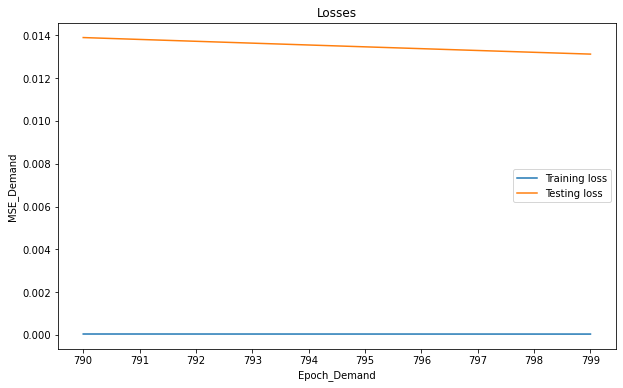

In [24]:
# Zoom in by fill in start_epoch and end_epoch
def zoom_learning_curve(start_epoch,end_epoch,training_loss,validation_loss):
    plt.figure(figsize=(10,6))
    plt.plot(training_loss[start_epoch:end_epoch], label="Training loss")
    plt.plot(validation_loss[start_epoch:end_epoch], label="Testing loss")
    plt.title("Losses")
    plt.xlabel("Epoch_Demand")
    plt.ylabel("MSE_Demand")
    position=range(end_epoch-start_epoch)
    labels=range(start_epoch,end_epoch)
    plt.xticks(position, labels)
    plt.legend()

zoom_learning_curve(start_epoch= 790 ,end_epoch = 800,training_loss=train_loss,validation_loss = val_loss)

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast value and calculating the RMSE.
>**Instruction** : <br>
Follow the instructor guidance to create the evaluation of the model <br>

It consists of 4 sections :<br>

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br>
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data 


In [25]:
# Section 1 : Make predictions
### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction= torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))
### END SOLUTION

In [26]:
# Section 3 : Invert predictions
### BEGIN SOLUTION
y_train_prediction= scaler.inverse_transform(y_train_prediction.numpy())
y_train = scaler.inverse_transform(trainY.numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.numpy())
y_test = scaler.inverse_transform(testY.numpy())

### END SOLUTION

In [27]:
### BEGIN SOLUTION
print("Test Data\t\t\tForecast Data")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")
### END SOLUTION

Test Data			Forecast Data
[300.]		[297.20953]
[310.]		[306.33804]
[320.]		[315.34247]
[330.]		[324.2172]
[340.]		[332.95724]
[350.]		[341.55798]
[360.]		[350.01526]
[370.]		[358.3255]
[380.]		[366.48563]
[390.]		[374.4931]


In [28]:
# Section 4 : Calculate root mean squared error for both train and test data 
### BEGIN SOLUTION
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

### END SOLUTION


Train Score: 0.50 RMSE
Test Score: 9.25 RMSE


# Step 6 : Forecast Plot 
You may turn the `original_plot = True` observe how the sliding window (data sequence) take place in the model.
>**Instruction** : <br>
Follow the instructor guidance to create a function for plotting the result of the univariate single step <br>

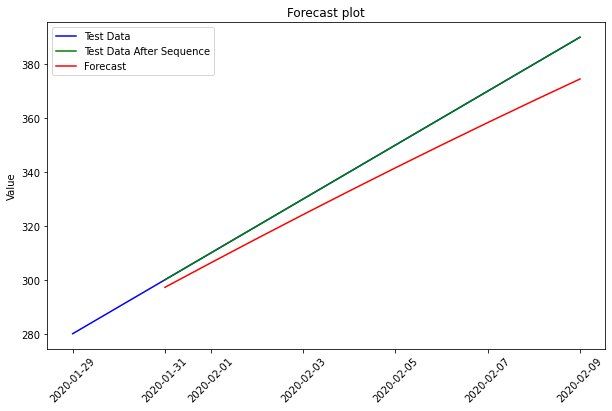

In [29]:
def single_step_plot(original_test_data,sequence_test_data,forecast_data,test_time,window_size,original_plot =False):
    ### BEGIN SOLUTION
    
    # Take the time index after data sequence
    sequence_test_time = test_time[window_size:]
    
    plt.figure(figsize=(10,6))
    
    if original_plot:
        plt.plot(test_time,original_test_data,color="blue",label = 'Test Data')
        
    plt.plot(sequence_test_time,sequence_test_data,color="green", label = 'Test Data After Sequence')
    plt.plot(sequence_test_time,forecast_data,color="red", label = 'Forecast')
    plt.xticks(rotation = 45)
    plt.ylabel("Value")
    plt.title("Forecast plot")
    plt.legend()
    ### END SOLUTION

single_step_plot(original_test_data = test_data,
                 sequence_test_data = y_test,
                 forecast_data = y_test_prediction,
                 test_time = test_time,
                 window_size = window_size,
                 original_plot = True)   

# Part 2 : Exercise for Univariate 
## Task : Using LSTM to create a model that can predict latest sales of shampoo

## Hyperparameter
>**Instruction** : <br>
You are required to fill `None` with suitable value to make the model converge.

>**Expected Result :**<br>
Your RMSE must fulfil these criteria <br>
`Train Score <=  150 RMSE`<br>
`Test Score: <=  150 RMSE`<br>

In [30]:
#Hyperparameter

### BEGIN SOLUTION
num_epochs_shampoo = 400
split_ratio_shampoo = 0.80
batch_size_shampoo = 10
window_size_shampoo = 3

#Hidden Layer for LSTM
hidden_dim = 64

### END SOLUTION


# Step 1 : Data Preparation
>**Instruction** : <br>
Read the `CSV` file using `pd.read_csv`<br>
Your file path `../../datasets/others/shampoo-sales.csv`

>**Expected Result** : <br>
Example of the first 5 data

month| sales
---|---
0| 1-01|    266.0
1| 1-02|    145.9
2| 1-03|    183.1
3| 1-04|    119.3
4| 1-05|    180.3

In [31]:
# Read CSV file 

### BEGIN SOLUTION
shampoo = pd.read_csv('../../datasets/others/shampoo-sales.csv')
### END SOLUTION

shampoo.head() 

,month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


>**Instruction** : <br>
Set the index as 'month' using `df.set_index`

>**Expected Result** : <br>
Example of the first 5 data

month| month| sales
---|---|---
1-01| 1-01|    266.0
1-02| 1-02|    145.9
1-03| 1-03|    183.1
1-04| 1-04|    119.3
1-05| 1-05|    180.3

In [32]:
### BEGIN SOLUTION
shampoo_ts =  shampoo.set_index(shampoo['month'])  
### END SOLUTION

shampoo_ts.head() 

,month,sales
month,,
1-01,1-01,266.0
1-02,1-02,145.9
1-03,1-03,183.1
1-04,1-04,119.3
1-05,1-05,180.3


>**Instruction** : <br>
Save the data in `Series` format using `pd.Series`

>**Expected Result** : <br>
Example of the first 5 rows:

month|---
---|---
1-01|    266.0
1-02|    145.9
1-03|    183.1
1-04|    119.3
1-05|    180.3

In [33]:
### START SOLUTION
shampoo_ts = pd.Series(shampoo_ts['sales'])
### END SOLUTION
shampoo_ts.head()

month
1-01    266.0
1-02    145.9
1-03    183.1
1-04    119.3
1-05    180.3
Name: sales, dtype: float64

Text(0.5, 1.0, 'Time Series plot ')

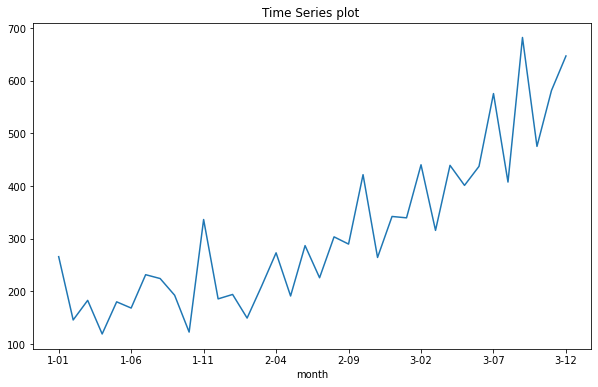

In [34]:
plt.figure(figsize=(10,6))
shampoo_ts.plot()
plt.title("Time Series plot ")

## Data Splitting
>**Instruction** : <br>
Split the data using indexing. Your data should be splitted into `train_data_shampoo` and `test_data_shampoo`. Do remember to save the time index for train data and test data as well. Save the time index as `train_time_shampoo` and `test_time_shampoo`.

In [35]:
# Split data by indexing 
split_data_shampoo = round(len(shampoo_ts)*split_ratio_shampoo)

In [36]:
# Data Splitting
train_data_shampoo = shampoo_ts[:split_data_shampoo]
test_data_shampoo = shampoo_ts[split_data_shampoo:]
train_time_shampoo = train_data_shampoo.index
test_time_shampoo = test_data_shampoo.index

## Data Standardization
>**Instruction** : <br>
Use `StandardScaler()` to  standardize the data and save your data scaler into `scaler_shampoo`.<br>
Train and test scaled data into `scaler_train_shampoo_data ` and `scaler_test_shampoo_data`.<br>

Example :<br>
`scaler_train_shampoo_data = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))`



In [37]:
### BEGIN SOLUTION
scaler_shampoo = StandardScaler().fit(train_data_shampoo.values.reshape(-1,1))
scaler_train_shampoo_data = scaler_shampoo.transform(train_data_shampoo.values.reshape(-1,1))
scaler_test_shampoo_data = scaler_shampoo.transform(test_data_shampoo.values.reshape(-1,1))

### END SOLUTION

## Data Sequencing 
>**Instruction** : <br>
Use `univariate_single_step` that was defined in part 1 to perform sliding window by taking the scaled data and save your data into respective `x` and `y` variable.<br>

Example :<br>
`trainX_shampoo ,trainY_shampoo =  univariate_single_step(scaler_train_shampoo_data,window_size_shampoo)`


In [38]:
### BEGIN SOLUTION
trainX_shampoo ,trainY_shampoo =  univariate_single_step(scaler_train_shampoo_data,window_size_shampoo)
testX_shampoo , testY_shampoo = univariate_single_step(scaler_test_shampoo_data,window_size_shampoo)
### END SOLUTION

print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")


trainX shape:(26, 3, 1) trainY shape:(26, 1)

testX shape:(4, 3, 1) testX shape:(4, 1)


## Data Transform
>**Instruction** : <br>
Transform the data from `ndarray` to `torch tensor`<br>

Example :<br>
`trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)`<br>
`trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)`<br>

In [39]:
# Transform numpy to Pytorch tensor

### BEGIN SOLUTION
trainX_shampoo = torch.from_numpy(trainX_shampoo).type(torch.Tensor)
trainY_shampoo = torch.from_numpy(trainY_shampoo).type(torch.Tensor)
testX_shampoo = torch.from_numpy(testX_shampoo).type(torch.Tensor)
testY_shampoo = torch.from_numpy(testY_shampoo).type(torch.Tensor)
### END SOLUTION

print(f"trainX shape:{trainX_shampoo.shape} trainY shape:{trainY_shampoo.shape}\n")
print(f"testX shape:{testX_shampoo.shape} testX shape:{testY_shampoo.shape}")

trainX shape:torch.Size([26, 3, 1]) trainY shape:torch.Size([26, 1])

testX shape:torch.Size([4, 3, 1]) testX shape:torch.Size([4, 1])


## Data Iterator
>**Instruction** : <br>
You are required to create data iterator to enable the data to be stored in batches<br>

Example :<br>
`train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)`<br>
`train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)`

In [40]:
# Create Iterator

### BEGIN SOLUTION
train_dataset_shampoo = TensorDataset(trainX_shampoo, trainY_shampoo)
train_iter_shampoo = DataLoader(train_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)

test_dataset_shampoo = TensorDataset(testX_shampoo, testY_shampoo)
test_iter_shampoo = DataLoader(test_dataset_shampoo,batch_size=batch_size_shampoo,shuffle=False)
### END SOLUTION

# Step 2 : LSTM Model Configuration
>**Instruction** : <br>
You are required to create an LSTM model configuration for both Vanilla LSTM and Bidirectional LSTM. The hints below may help you with the configuration<br>

Hints : 

>**How to initialize LSTM ?**<br>
 1.`nn.LSTM(number of feature , number of hidden unit,number of layer)`<br>
 2.`nn.Linear(number of hidden, number of step)`<br>

>**The dimension for LSTM in `forward()` method**<br>
*if `num_directions` = 2 indicate it is Bidirectional LSTM*<br><br>
*Input*<br>
`input(batch,seq_len, input_size)`<br>
`h_0 (num_layers * num_directions, batch, hidden_size)`<br>
`c_0 (num_layers * num_directions, batch, hidden_size)`<br><br>
*Output*<br>
`output ( batch,seq_len, num_directions * hidden_size)`<br>
`h_n (num_layers * num_directions, batch, hidden_size)`<br>
`c_n (num_layers * num_directions, batch, hidden_size)`<br><br>

In [41]:
class LSTM_exercise(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, n_step) :
            super(LSTM_exercise, self).__init__()
            ### BEGIN SOLUTION
            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers
            
            self.n_step = n_step 

            # Building your LSTM
            # batch_first=True 
            # Configuration -> (number of feature , number of hidden unit,number of layer)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim,n_step)
            ### END SOLUTION


        def forward(self, x):
            ### BEGIN SOLUTION
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state with zeros
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # we just want last time step hidden states(output)
            out = out[:, -1, :]
            out = self.fc(out)
            ### END SOLUTION
            return out

In [42]:
class BidirectionalLSTM_exercise(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers,n_step):
        super(BidirectionalLSTM, self).__init__()
        ### BEGIN SOLUTION
        # Number of feature of data
        self.n_feature = n_feature
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        
        # Number of step ,step =1 -> single step forecast
        self.n_step = n_step 

        # Building your LSTM
        # batch_first=True 
        # Configuration -> (number of feature , number of hidden unit,number of layer)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, n_step)
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]

        # Index hidden state of last time step
        out = self.fc(out)
        ### END SOLUTION
        return out

## Input Model 
>**Instruction** : <br>
Feel free to use any type of LSTM configuration. Please input the correct attributes and experiment with it. Save your model with the name `model_shampoo `<br>
Example :<br>
`model_shampoo = LSTM_exercise(n_feature=number_of_time_series, hidden_dim=hidden_dim,num_layers=num_layers,n_step=n_step )`


In [43]:
# Arguments for LSTM model

torch.manual_seed(123)
### BEGIN SOLUTION
number_of_time_series = 1 
timestep = 1
n_step =1 

# num_layers : 1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

# Vanila ,Stacked LSTM
model_shampoo = LSTM_exercise(n_feature=number_of_time_series, hidden_dim=hidden_dim,num_layers=num_layers,n_step=n_step )

# Bidirectional LSTM
# model_shampoo = BidirectionalLSTM_exercise(n_feature=number_of_time_series, hidden_dim=hidden_dim, num_layers=num_layers,n_step=n_step )
### END SOLUTION


>**Instruction** : <br>
Use `MSELoss` as the loss function and `Adam` as the optimizer. You are required to save `MSELoss` into the variable name `loss_fn_shampoo` and `Adam` optimizer into `optimizer_shampoo`<br>

In [44]:
# Define MSE as Loss function 
### BEGIN SOLUTION
loss_fn_shampoo = torch.nn.MSELoss()

# Set up optimizer 
optimizer_shampoo = torch.optim.Adam(model_shampoo.parameters(),lr=0.001)
### END SOLUTION

# Step 3 : Training 
>**Instruction** : <br>
Write your own training function that will be used to fit the data to the model<br>

In [45]:
torch.manual_seed(123)
def training_exercise(num_epochs,train_iter,test_iter,optimizer,loss_fn,model):
    # Create a list of zero value to store the averaged value
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    ### BEGIN SOLUTION
    
    for t in range(num_epochs):
        
        # Initial the value to be zero to perform cummulative sum 
        running_loss_train = 0
        running_loss_valid = 0
        
        # For loop to loop through each data in the data iterator
        for _,(train_X,train_Y) in enumerate(train_iter):
            
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between batches
            optimizer.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimizer.step()
            
            # Since the loss_train.item will only return the average loss based number of batches
            # loss_train.item()*train_X.size(0) -> to make it multiply with batch size 
            running_loss_train += loss_train.item()*train_X.size(0)
            
        # Average the loss base on total batch size ,train_iter.dataset is use to get the total batch size 
        epoch_loss_train = running_loss_train /len(train_iter.dataset)
        # Store the averaged value
        train_loss[t] = epoch_loss_train
        
        # Validate the test data loss
        with torch.no_grad():
            # For loop to loop through each data in the data iterator
            for j,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to ensure the predicted output (y_test_pred) same size with test_y shape
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss 
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each batch
                running_loss_valid += loss_test.item()*test_X.size(0)
                
        # Average the loss base on total batch size 
        epoch_loss_test =running_loss_valid /len(test_iter.dataset)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
        
    ### END SOLUTION
    return train_loss,val_loss

In [46]:
# Start Training 
train_loss_shampoo,val_loss_shampoo = training_exercise(num_epochs_shampoo,train_iter_shampoo,test_iter_shampoo,optimizer_shampoo,loss_fn_shampoo,model_shampoo)

# Step 4 : Validation
A train loss and val loss is plotted to define how well the data fits the model

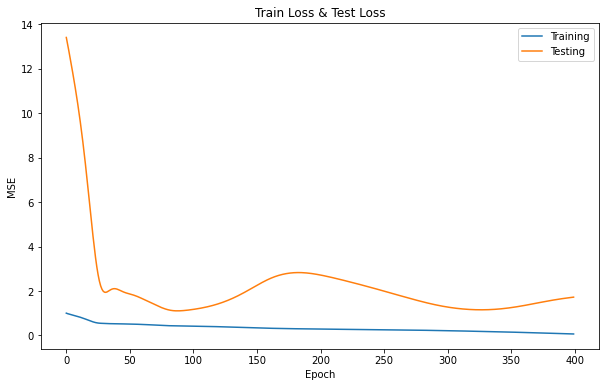

Epoch : 0 , training loss : 1.0008795307232783 , validation loss : 13.410648345947266
Epoch : 1 , training loss : 0.9788342668459966 , validation loss : 13.114419937133789
Epoch : 2 , training loss : 0.9629146823516259 , validation loss : 12.803783416748047
Epoch : 3 , training loss : 0.9474550852408776 , validation loss : 12.487029075622559
Epoch : 4 , training loss : 0.9320912682093107 , validation loss : 12.165029525756836
Epoch : 5 , training loss : 0.9166619869378897 , validation loss : 11.836613655090332
Epoch : 6 , training loss : 0.9010394215583801 , validation loss : 11.499817848205566
Epoch : 7 , training loss : 0.8851064351888803 , validation loss : 11.152326583862305
Epoch : 8 , training loss : 0.868752814256228 , validation loss : 10.791679382324219
Epoch : 9 , training loss : 0.8518761763205895 , validation loss : 10.4154052734375
Epoch : 10 , training loss : 0.8343846935492295 , validation loss : 10.021139144897461
Epoch : 11 , training loss : 0.8162026863831741 , valida

In [47]:
learning_curve(num_epochs_shampoo,train_loss_shampoo,val_loss_shampoo)

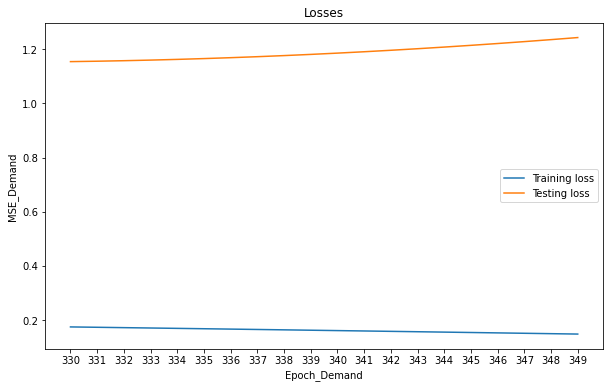

In [48]:
# Zoom in to visualize the graph by fill in start_epoch and end_epoch that want to analyse
zoom_learning_curve(start_epoch=330, end_epoch = 350, training_loss = train_loss_shampoo, validation_loss=val_loss_shampoo)

## Step 5 : Evaluation
This section is to inference the model by feeding in testing data and using the forecasted value to calculate the RMSE.

>**Instruction** : <br>
Evaluate the model by input the `trainX_shampoo` data and `testX_shampoo` data. Remember to reshape it. <br>
It consists of 4 sections :<br>
Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [49]:
# Section 1 : Make predictions

### BEGIN SOLUTION
with torch.no_grad():
    y_train_prediction_shampoo= model_shampoo(trainX_shampoo)
    y_test_prediction_shampoo= model_shampoo(testX_shampoo)
### END SOLUTION

# Section 2 : Reshape to original data
### BEGIN SOLUTION
y_train_prediction_shampoo = torch.reshape(y_train_prediction_shampoo,(y_train_prediction_shampoo.shape[0],y_train_prediction_shampoo.shape[1]))
trainY_shampoo = torch.reshape(trainY_shampoo,(trainY_shampoo.shape[0],trainY_shampoo.shape[1]))
y_test_prediction_shampoo = torch.reshape(y_test_prediction_shampoo,(y_test_prediction_shampoo.shape[0],y_test_prediction_shampoo.shape[1]))
testY_shampoo = torch.reshape(testY_shampoo,(testY_shampoo.shape[0],testY_shampoo.shape[1]))
### END SOLUTION

In [50]:
# Section 3 : Invert predictions
### BEGIN SOLUTION
y_train_pred_shampoo = scaler_shampoo.inverse_transform(y_train_prediction_shampoo)
y_train_shampoo = scaler_shampoo.inverse_transform(trainY_shampoo)
y_test_pred_shampoo = scaler_shampoo.inverse_transform(y_test_prediction_shampoo)
y_test_shampoo = scaler_shampoo.inverse_transform(testY_shampoo)
### END SOLUTION

In [51]:
print("y-test\t\ty-predict")
for i in range(len(y_test_shampoo)):
    print(f"{y_test_shampoo[i]}\t\t{y_test_pred_shampoo[i]}")

y-test		y-predict
[682.]		[499.81732]
[475.3]		[466.7968]
[581.3]		[473.0227]
[646.9]		[531.5617]


In [52]:
# Section 4 : Calculate root mean squared error for both train and test data
### BEGIN SOLUTION
trainScore_shampoo = math.sqrt(mean_squared_error(y_train_shampoo, y_train_pred_shampoo))
print('Train Score: %.2f RMSE' % (trainScore_shampoo))
testScore_shampoo = math.sqrt(mean_squared_error(y_test_shampoo, y_test_pred_shampoo))
print('Test Score: %.2f RMSE' % (testScore_shampoo))
### END SOLUTION

Train Score: 22.91 RMSE
Test Score: 120.72 RMSE


# Step 6 : Forecast Plot
>Instruction :<br>
Use `single_step_plot` function to plot the forecasted result.

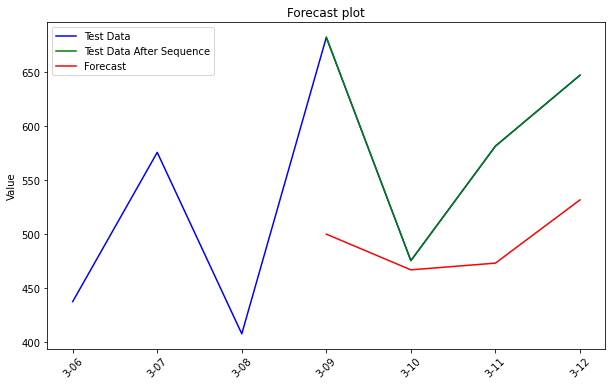

In [53]:
### BEGIN SOLUTION
single_step_plot(original_test_data = test_data_shampoo,
                 sequence_test_data = y_test_shampoo,
                 forecast_data = y_test_pred_shampoo,
                 test_time = test_time_shampoo,
                 window_size = window_size_shampoo,
                 original_plot = True ) 
### END SOLUTION

As you can see, some data will be 'skipped' in the output. The data that gets into the plot is based on `window_size_shampoo` that you had defined earlier. The `window_size_shampoo` massages the input data and is treated as a `feature` for the model.

## Summary
From this tutorial, you should have learned:

1. The flow of using LSTM to perform univariate forecasting
2. The configuration of Vanila LSTM, Bidirectional LSTM <br>

Congratulations, that concludes this lesson.<br>

Save your learning curve function `learning_curve` , zoom learning curve function `zoom_learning_curve` and forecast plot `single_step_plot` into the `data_module.py`

Create a new `.py` file to save your Vanila LSTM class LSTM , Bidirectional LSTM class BidirectionalLSTM and training function `training` into a module and name it `deep_learning_module`. It will be used in the later tutorial.<br>

Please proceed to other notebook for other type of data in LSTM forecasting  <br>

1. ~~*[04 - LSTM_Univariate_SingleStep]*~~ *Complete*
2. [04 - LSTM_Univariate_MultiStep.ipynb](./04%20-%20LSTM_Univariate_MultiStep.ipynb)<br>
3. [04 - LSTM_Multivariate_Univariate_SingleStep](./04%20-%20LSTM_Multivariate_Univariate_SingleStep.ipynb)<br>
4. [04 - LSTM_Multivariate_Univariate_MultiStep](./04%20-%20LSTM_Multivariate_Univariate_MultiStep.ipynb)<br>

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
2. [Animated RNN, LSTM and GRU](https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45)
3. [pytorch中LSTM的细节分析理解](https://blog.csdn.net/shunaoxi2313/article/details/99843368?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-2.control&dist_request_id=&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-2.control)